## Info

This notebook has code for performing GWAS with EMMAX

## Set up env

### Load modules

In [3]:
import sys,os,re,fnmatch,glob,shutil
import subprocess,itertools
import numpy as np
import pandas as pd
import limix
import pandas_plink
import pylab as pl
import allel
import h5py
import matplotlib.pyplot as plt
import time,gzip

In [2]:
%matplotlib inline

In [2]:
%load_ext rpy2.ipython

In [8]:
%%R
library("corrplot")
library("FactoMineR")
library("factoextra")
library("missMDA")
library("qqman")
library("snpStats")
library("IntAssoPlot")
library("tidyverse")
library("vcfR")
library("ggforce")

R[write to console]: Error in library("vcfR") : there is no package called ‘vcfR’




Error in library("vcfR") : there is no package called ‘vcfR’


RInterpreterError: Failed to parse and evaluate line 'library("corrplot")\nlibrary("FactoMineR")\nlibrary("factoextra")\nlibrary("missMDA")\nlibrary("qqman")\nlibrary("snpStats")\nlibrary("IntAssoPlot")\nlibrary("tidyverse")\nlibrary("vcfR")\nlibrary("ggforce")\n'.
R error message: 'Error in library("vcfR") : there is no package called ‘vcfR’'

In [4]:
%%R

sessionInfo()

R version 3.5.1 (2018-07-02)
Platform: x86_64-conda_cos6-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /n/home00/akautt/.conda/envs/work-2/lib/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggforce_0.2.2       vcfR_1.10.0         forcats_0.4.0      
 [4] stringr_1.4.0       dplyr_0.8.1         purrr_0.3.2        
 [7] readr_1.3.1         tidyr_0.8.3         tibble_2.1.3       
[10] tidyverse_1.2.1     IntAssoPlot_0.99.21 ggrepel_0.8.2      
[13] reshape2_1.4.3      S

### Define functions

In [4]:
slurm_ids = {} # create dictionary to catch slurm job IDs for all jobs submitted by function below

def make_slurm(cmd_string,jobName,echo=False,run=False,write=True,mem='2gb',time='00-12:00',N='1',n='1',c='1',
               array='1-1%1',p='hoekstra,shared'):
    SLURM = ('''#!/bin/bash\n'''
           '''#SBATCH -N {nodes}\n'''
           '''#SBATCH -n {tasks}\n'''
           '''#SBATCH -c {cpus}\n'''
           '''#SBATCH -t {time}\n'''
           '''#SBATCH --mem={mem}\n'''
           '''#SBATCH -p {partition}\n'''
           '''#SBATCH --array {array}\n'''
           '''#SBATCH --job-name {jobName}\n'''
           '''#SBATCH -e {log_dir}/%x_%A_%a.out\n'''
           '''#SBATCH -o {log_dir}/%x_%A_%a.out\n'''
           '''{cmd_string}\n''').format(
                jobName=jobName,cmd_string=cmd_string,partition=p,time=time,mem=mem,tasks=n,cpus=c,nodes=N,
                array=array,log_dir=log_dir)

    # Show SLURM command?
    if echo == True:
        print(SLURM)

    # Write to file and/or submit to SLURM?
    if write == True:
        filename = '%s/%s.slurm' % (scripts_dir,jobName)
        with open(filename, 'w') as outfile:
            outfile.write(SLURM)
            print('"%s" slurm script written to %s\n' %(jobName, scripts_dir))
        # Run
        if run == True:
            sbatch_response = subprocess.getoutput('sbatch {}'.format(filename))
            print(sbatch_response)
            job_id = sbatch_response.split(' ')[-1].strip()
            slurm_ids[jobName] = job_id
            
    return(SLURM)

def sacct_extract(job_name):
    
    jobstring = ','.join( jobID for name,jobID in slurm_ids.items() if job_name in name )

    sacct_out = [ subprocess.getoutput('sacct -j {}'.format(jobstring)) ]

    output = []
    for line in sacct_out:
        jobs = line.split("\n")
        for entry in jobs:
            if 'akautt' in entry:
                fields = entry.split()
                output.append(fields[0:9])
    print(*output,sep="\n")

### Set up dirs and paths

In [5]:
project = "Peromyscus_polionotus"
stem_path = "/n/holylfs03/LABS/hoekstra_lab/Users/akautt/projects/"

#set main data folder for the project
project_dir = stem_path + project
data_dir = os.path.join(project_dir,'data')
results_dir = os.path.join(project_dir,'results')
scripts_dir = os.path.join(project_dir,'scripts')
log_dir = os.path.join(scripts_dir,'logs')
list_dir = os.path.join(project_dir,'lists')
assoc_dir = os.path.join(results_dir,'association')
if not os.path.exists(assoc_dir):
    os.mkdir(assoc_dir)
temp_dir = os.path.join(project_dir,'temp')
if not os.path.exists(temp_dir):
    os.mkdir(temp_dir)
emmax_dir = os.path.join(assoc_dir,'emmax')
if not os.path.exists(emmax_dir):
    os.mkdir(emmax_dir)
    
genome_path = '/n/holylfs03/LABS/hoekstra_lab/Lab/PUBLIC/GENOMES/Ppol1.3_chr_NCBI'
annot_path = '/n/holylfs03/LABS/hoekstra_lab/Lab/PUBLIC/ANNOTATIONS/Ppol1.3_chr_NCBI'
refseq = os.path.join(genome_path,'Ppol_1.3.3.chromosomes-unplaced_scaffolds.fasta')
annotation = os.path.join(annot_path,'Ppol1.3_chr_NCBI.corrected.merged-with-Apollo.May2020.sorted.gff3')

### Mc1r and Agouti BAC region

In [6]:
BAC_region_file = os.path.join(list_dir,'mc1r_agouti_BACs.bed')

if not os.path.exists(BAC_region_file):
    with open(BAC_region_file,'w') as outhandle:
        print('chr4','9697970','9924483','agouti',sep='\t',file=outhandle)
        print('chr5','55763923','55981569','mc1r',sep='\t',file=outhandle)

### Software

EMMAX http://genetics.cs.ucla.edu/emmax/ -> comes as pre-compiled binaries


GEC http://grass.cgs.hku.hk/gec/index.php

## Prepare GT files

Keep SNPs and indels. As long as they are biallelic, they can be used for association tests

### Subset and filter vcf

In [29]:
vcf_file = '/n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/popgen_vcfs/vars/ALL.vcf.gz'

sample_string = ','.join(samples)

if os.path.exists(os.path.join(assoc_dir,'POALB.biallelic.vcf.gz')):

    bcftools_filter = ('''\nexport BCFTOOLS_PLUGINS="/n/home00/akautt/software/bcftools/plugins"\n\n'''
                        '''bcftools view {vcf_file} --samples {samples} -O u '''
                        '''| bcftools view -M2 --min-ac 1 -i 'ALT !~ "*"' -O z '''  #   && STRLEN(REF) == 1 && TYPE="snp"
                        '''-o {assoc_dir}/POALB.biallelic.vcf.gz && tabix {assoc_dir}/POALB.biallelic.vcf.gz''').format(
                        vcf_file=vcf_file,assoc_dir=assoc_dir,samples=sample_string)
    
    slurm = make_slurm(run=True,echo=False,jobName='bcftools_filter',cmd_string=bcftools_filter,
                       mem='100mb',time='0-12:00',p='commons')

"bcftools_filter" slurm script written to /n/holylfs03/LABS/hoekstra_lab/Users/akautt/projects/Peromyscus_polionotus/scripts

Submitted batch job 53248989


In [32]:
sacct_extract('bcftools_filter')

['53248989_1', 'bcftools_+', 'akautt', 'commons', 'holy2a08107', '00:00:28', '12:00:00', 'COMPLETED', '0:0']


-> file is so small that most things can be run straight from notebook. No need to submit jobs

In [33]:
%%script env assoc_dir="$assoc_dir" bash

vt-0.57 peek ${assoc_dir}/POALB.biallelic.vcf.gz 2>&1 | tee ${assoc_dir}/POALB.biallelic.vtpeek

peek v0.5

options:     input VCF file            /n/holylfs03/LABS/hoekstra_lab/Users/akautt/projects/Peromyscus_polionotus/results/association/POALB.biallelic.vcf.gz


stats: no. of samples                     :        168
       no. of chromosomes                 :         24

       ========== Micro variants ==========

       no. of SNP                         :      22699
           2 alleles                      :           22699 (2.24) [15694/7005]

       no. of Indel                       :       1486
           2 alleles                      :            1486 (3.64) [1166/320]

       no. of SNP/MNP                     :          7
           2 alleles                      :               7 (2.50) [5/2]

       ++++++ Other useful categories +++++

       no. of block substitutions         :          7
           2 alleles                      :               7 (2.50) [5/2]

       ============== VNTR ===============

       no. of VNTRs                       :          0

 

### Check for samples with excessive missing data (e.g. >50%) and remove them

In [34]:
%%script env assoc_dir="$assoc_dir" bash

if [ ! -f ${assoc_dir}/POALB.biallelic.imiss ]; then
    plink --vcf ${assoc_dir}/POALB.biallelic.vcf.gz \
    --memory 2000 --threads 1 \
    --double-id --allow-extra-chr --chr-set 23 no-xy no-mt \
    --missing --out ${assoc_dir}/POALB.biallelic; fi

if [ ! -f ${assoc_dir}/POALB.miss50perc.samplelist.tsv ]; then
    awk 'BEGIN{OFS="\t"} !/FID/ && $6>0.5 {print $1,$2}' ${assoc_dir}/POALB.biallelic.imiss \
    > ${assoc_dir}/POALB.miss50perc.samplelist.tsv; fi

PLINK v1.90b6.15 64-bit (21 Jan 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /n/holylfs03/LABS/hoekstra_lab/Users/akautt/projects/Peromyscus_polionotus/results/association/POALB.biallelic.log.
Options in effect:
  --allow-extra-chr
  --chr-set 23 no-xy no-mt
  --double-id
  --memory 2000
  --missing
  --out /n/holylfs03/LABS/hoekstra_lab/Users/akautt/projects/Peromyscus_polionotus/results/association/POALB.biallelic
  --threads 1
  --vcf /n/holylfs03/LABS/hoekstra_lab/Users/akautt/projects/Peromyscus_polionotus/results/association/POALB.biallelic.vcf.gz

128653 MB RAM detected; reserving 2000 MB for main workspace.
--vcf:
/n/holylfs03/LABS/hoekstra_lab/Users/akautt/projects/Peromyscus_polionotus/results/association/POALB.biallelic-temporary.bed
+
/n/holylfs03/LABS/hoekstra_lab/Users/akautt/projects/Peromyscus_polionotus/results/association/POALB.biallelic-temporary.bim
+
/n/holylfs03/LABS/hoekst

In [35]:
%%script env assoc_dir="$assoc_dir" bash

if [ ! -f ${assoc_dir}/POALB.biallelic.miss50perc.vcf.gz ]; then
    vcftools-0.1.17 --gzvcf ${assoc_dir}/POALB.biallelic.vcf.gz \
    --remove ${assoc_dir}/POALB.miss50perc.samplelist.tsv \
    --recode --stdout | bgzip > ${assoc_dir}/POALB.biallelic.miss50perc.vcf.gz \
    && tabix ${assoc_dir}/POALB.biallelic.miss50perc.vcf.gz; fi


VCFtools - 0.1.17
(C) Adam Auton and Anthony Marcketta 2009

Parameters as interpreted:
	--gzvcf /n/holylfs03/LABS/hoekstra_lab/Users/akautt/projects/Peromyscus_polionotus/results/association/POALB.biallelic.vcf.gz
	--remove /n/holylfs03/LABS/hoekstra_lab/Users/akautt/projects/Peromyscus_polionotus/results/association/POALB.miss50perc.samplelist.tsv
	--recode
	--stdout

Using zlib version: 1.2.7
Excluding individuals in 'exclude' list
After filtering, kept 152 out of 168 Individuals
Outputting VCF file...
After filtering, kept 24192 out of a possible 24192 Sites
Run Time = 19.00 seconds


### Convert to bed and tped with plink (input format for EMMAX)

In [71]:
%%script env assoc_dir="$assoc_dir" bash

maf="0.05"; geno="0.1"; hwe="0.001"
stem="biallelic.miss50perc.maf${maf}geno${geno}hwe${hwe}"

if [ ! -f ${assoc_dir}/POALB.${stem}.tped ]; then
    plink --vcf ${assoc_dir}/POALB.biallelic.miss50perc.vcf.gz \
    --memory 2000 --threads 1 \
    --double-id --allow-extra-chr --chr-set 23 no-xy no-mt \
    --set-missing-var-ids '@:#' \
    --recode12 --output-missing-genotype 0 --transpose \
    --maf $maf --geno $geno --hwe $hwe \
    --out ${assoc_dir}/POALB.${stem} ; fi
    
    
if [ ! -f ${assoc_dir}/POALB.${stem}.bed ]; then
    plink --vcf ${assoc_dir}/POALB.biallelic.miss50perc.vcf.gz \
    --memory 2000 --threads 1 \
    --double-id --allow-extra-chr --chr-set 23 no-xy no-mt \
    --set-missing-var-ids '@:#' --make-bed \
    --maf $maf --geno $geno --hwe $hwe \
    --out ${assoc_dir}/POALB.${stem}; fi

PLINK v1.90b6.15 64-bit (21 Jan 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Note: --recode12 flag deprecated.  Use "--recode 12 ...".
Logging to /n/holylfs03/LABS/hoekstra_lab/Users/akautt/projects/Peromyscus_polionotus/results/association/POALB.biallelic.miss50perc.maf0.05geno0.1hwe0.001.log.
Options in effect:
  --allow-extra-chr
  --chr-set 23 no-xy no-mt
  --double-id
  --geno 0.1
  --hwe 0.001
  --maf 0.05
  --memory 2000
  --out /n/holylfs03/LABS/hoekstra_lab/Users/akautt/projects/Peromyscus_polionotus/results/association/POALB.biallelic.miss50perc.maf0.05geno0.1hwe0.001
  --output-missing-genotype 0
  --recode 12
  --set-missing-var-ids @:#
  --threads 1
  --transpose
  --vcf /n/holylfs03/LABS/hoekstra_lab/Users/akautt/projects/Peromyscus_polionotus/results/association/POALB.biallelic.miss50perc.vcf.gz

Note: --transpose flag deprecated.  Use "--recode transpose ...".
128653 MB RAM detected; reserv

## Generate phenotype input files for EMMAX

In [46]:
pheno_master_miss50perc_withPCA = pd.read_csv(
    os.path.join(assoc_dir,'pheno_master_miss50perc_withPCA.tsv'),sep='\t')

# which traits are actually variable and what's the variance?
pd.set_option('display.max_rows', 40)
pheno_master_miss50perc_withPCA.var(axis=0, skipna=True)

DORSAL       0.000000
FLANK        0.000000
Ventrum      0.106483
Tail         0.589890
Rumpshape    0.370488
               ...   
PC1          3.817353
PC2          2.538075
PC3          1.951992
PC4          1.534021
PC5          1.238263
Length: 45, dtype: float64

In [47]:
pheno_master_miss50perc_withPCA.describe()

,DORSAL,FLANK,Ventrum,Tail,Rumpshape,Rumpshadow,Ankleshadow,EARBASE,Eyebrow,Cheek,...,FLANK_Hue_SD,FLANK_Saturation_SD,VENTRUM_Brightness_SD,VENTRUM_Hue_SD,VENTRUM_Saturation_SD,PC1,PC2,PC3,PC4,PC5
count,152.0,152.0,152.000000,151.000000,149.000000,152.000000,152.000000,149.0,149.000000,145.000000,...,152.000000,152.000000,152.000000,152.000000,152.000000,1.520000e+02,1.520000e+02,1.520000e+02,1.520000e+02,1.520000e+02
mean,2.0,2.0,0.802632,1.877483,2.466443,0.664474,1.029605,2.0,1.513423,0.472414,...,0.612203,0.011362,16.410431,1.822121,0.004241,9.933574e-16,-3.739699e-16,8.414322e-16,3.505967e-17,1.037182e-15
std,0.0,0.0,0.326317,0.768043,0.608677,0.414059,0.201267,0.0,0.402468,0.644903,...,0.368271,0.005050,8.125979,0.744615,0.003212,1.953805e+00,1.593134e+00,1.397137e+00,1.238556e+00,1.112773e+00
min,2.0,2.0,0.000000,1.000000,1.000000,0.000000,0.500000,2.0,1.000000,0.000000,...,0.138407,0.001618,2.278017,0.388289,0.000447,-4.803856e+00,-4.861261e+00,-3.705166e+00,-4.385184e+00,-3.199754e+00
25%,2.0,2.0,0.500000,1.000000,2.000000,0.500000,1.000000,2.0,1.000000,0.000000,...,0.370505,0.007811,10.922371,1.249145,0.002167,-1.478783e+00,-1.041361e+00,-9.475916e-01,-9.378833e-01,-8.607747e-01
50%,2.0,2.0,1.000000,2.000000,2.000000,1.000000,1.000000,2.0,1.500000,0.000000,...,0.565736,0.010619,15.336082,1.757535,0.003500,-2.253298e-01,1.130142e-01,1.224329e-01,1.235876e-01,6.838560e-02
75%,2.0,2.0,1.000000,2.500000,3.000000,1.000000,1.000000,2.0,2.000000,1.000000,...,0.732166,0.013583,19.943036,2.327054,0.005069,1.250050e+00,1.142282e+00,9.371995e-01,8.672629e-01,7.885957e-01
max,2.0,2.0,1.500000,4.000000,4.000000,1.000000,2.000000,2.0,2.000000,2.000000,...,2.743766,0.027837,44.955983,3.828055,0.020705,5.588394e+00,4.397413e+00,3.223955e+00,2.708209e+00,2.293955e+00


In [48]:
# remove invariable traits, notes, means and sd of spec traits, and rename MEDIAN to median 
# for backwards compatibility (Brock switched at some point)

traits = list(pheno_master_miss50perc_withPCA.columns)
traits = [ trait for trait in traits if trait not in ['ANIMALID','DORSAL','FLANK','EARBASE',
            'BETWEENEYES','DATE','MEASURER','NOTES','pop'] ]
traits = [ trait for trait in traits if ("SPEC" not in trait and "MEAN" not in trait and "SD" not in trait) ]

#traits = [ trait.replace("MEDIAN","median") for trait in traits ]

traits

['Ventrum',
 'Tail',
 'Rumpshape',
 'Rumpshadow',
 'Ankleshadow',
 'Eyebrow',
 'Cheek',
 'Whisker',
 'Rostrum',
 'Dorsum_Brightness',
 'Dorsum_Hue',
 'Dorsum_Saturation',
 'Flank_Brightness',
 'Flank_Hue',
 'Flank_Saturation',
 'Ventrum_Brightness',
 'Ventrum_Hue',
 'Ventrum_Saturation',
 'PC1',
 'PC2',
 'PC3',
 'PC4',
 'PC5']

In [49]:
# generate pheno files. ID has to duplicated, following plink format (actually family ID and ind ID, but doesn't matter here)

for trait in traits:
    out_file = '%s/pheno_miss50perc_%s.tsv' %(assoc_dir,trait)
    
    if not os.path.exists(out_file):
        pheno = pheno_master_miss50perc_withPCA[['ANIMALID','ANIMALID',trait]]
        pheno.to_csv(out_file, sep='\t', index=False, header=False, na_rep='NA')

## Genotype likelihood-based PCA

Based on ANGSD GT likelihoods (see ANGSD notebook)

In [82]:
PCscores_file = '/n/holylfs03/LABS/hoekstra_lab/Users/brock/polionotus/angsd/POALB_PCscores.txt'

PCscores = pd.read_csv(PCscores_file, sep="\t")

PCscores_miss50perc = PCscores[~PCscores.samples.isin(excluded_samples)]

#PCscores = PCscores.rename(columns={'samples':'IID'})
PCcovar_miss50perc = PCscores_miss50perc[['samples','samples','PC1','PC2','PC3','PC4','PC5']] # duplicate sample ID - plink format
PCcovar_miss50perc.columns = ['#FID','IID','PC1','PC2','PC3','PC4','PC5'] # change header to that expected by plink2 for covariate file

# generate covariate file
out_file = os.path.join(assoc_dir,'covar_miss50perc_genPCscores.tsv')
if not os.path.exists(out_file):
    PCcovar_miss50perc.to_csv(out_file, sep='\t', index=False, header=True, na_rep='NA')
    
pd.set_option('display.max_rows', 10)
PCcovar_miss50perc

,#FID,IID,PC1,PC2,PC3,PC4,PC5
0,VSD142,VSD142,0.047101,-0.071038,0.063356,-0.071114,-0.037806
1,VSD143,VSD143,0.020383,-0.085641,0.099400,0.005721,0.065881
2,VSD195,VSD195,-0.017774,0.079555,0.006412,0.113150,-0.016755
3,VSD196,VSD196,0.043181,-0.050196,0.092543,-0.052822,-0.006568
4,VSD197,VSD197,0.001435,-0.009865,0.060391,0.073230,0.007889
...,...,...,...,...,...,...,...
162,VSD83,VSD83,-0.100008,-0.046201,-0.054707,-0.053625,0.014613
163,VSD84,VSD84,0.099445,-0.094261,-0.025021,-0.050885,-0.074519
165,VSD86,VSD86,0.110659,-0.045524,-0.051989,0.005203,0.040827
166,VSD87,VSD87,-0.115267,-0.017196,0.001515,-0.075491,-0.006140


In [87]:
# check if order of IDs is the same

list(PCscores_miss50perc['samples'])==list(pheno_master_miss50perc_withPCA['ANIMALID'])

True

### Correlations between traits and genetic PC scores

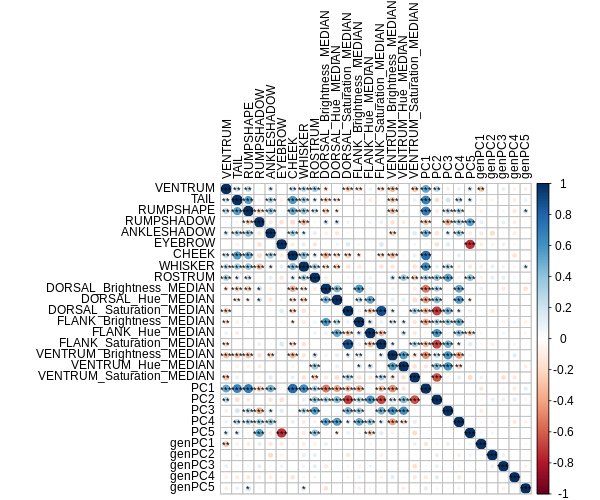

In [99]:
%%R -w 600 -h 500 -i assoc_dir

PC_dat <- read.table(paste0(assoc_dir,'/covar_miss50perc_genPCscores.tsv'), header=F) %>% 
    setNames(c("ANIMALID","IID","genPC1","genPC2","genPC3","genPC4","genPC5")) %>% select(-IID)

genPC_cor_mat <- left_join(pheno_master_miss50perc_withPCA, PC_dat, by="ANIMALID") %>% 
    select(-c(ANIMALID,MEASURER,DATE,NOTES,pop,starts_with("SPEC"))) %>%
    select(-c(DORSAL,FLANK,EARBASE,BETWEENEYES,contains("_MEAN"),contains("_SD"))) %>%
    cor(., method="pearson", use="complete.obs")

genPC_cor_mat_sig <- left_join(pheno_master_miss50perc_withPCA, PC_dat, by="ANIMALID") %>% 
    select(-c(ANIMALID,MEASURER,DATE,NOTES,pop,starts_with("SPEC"))) %>%
    select(-c(DORSAL,FLANK,EARBASE,BETWEENEYES,contains("_MEAN"),contains("_SD"))) %>%
    cor.mtest()

corrplot(genPC_cor_mat, p.mat=genPC_cor_mat_sig$p, tl.col="black", cl.cex=1, method="circle", 
        insig="label_sig", sig.level=c(.001, .01, .05), pch.cex=0.75, pch.col="black")

#method="number" will show actual corr. coefficient

In [102]:
%%R

# pull out order of traits based on clustering
trait_order <- rownames(reorder_cormat(genPC_cor_mat))

# tidy up cor. matrix
genPC_cor_mat_plot <- reorder_cormat(genPC_cor_mat) %>% as.data.frame() %>% rownames_to_column(var="Trait1") %>% 
    gather(key="Trait2", value="r", -Trait1) %>%
    mutate(Trait1=fct_relevel(Trait1, levels=trait_order)) %>%
    mutate(Trait2=fct_relevel(Trait2, levels=trait_order))

# ...and significance matrix (order both according to clustering)
genPC_cor_mat_sig_plot <- genPC_cor_mat_sig$p %>% as.data.frame() %>% 
    setNames(colnames(genPC_cor_mat)) %>% mutate(Trait1=rownames(genPC_cor_mat)) %>% 
    gather(key="Trait2", value="p", -Trait1) %>%
    mutate(significance = case_when(p < 0.001 ~ "***",
                                   p < 0.01 ~ "**",
                                   p < 0.05 ~ "*")) %>%
    mutate(Trait1=fct_relevel(Trait1, levels=trait_order)) %>%
    mutate(Trait2=fct_relevel(Trait2, levels=trait_order))

In [140]:
%%R -w 900 -h 800

ggplot(genPC_cor_mat_plot) +
    geom_point(aes(x=Trait1, y=Trait2, color=r, size=r)) +
    scale_color_gradient2(name="", limits=c(-1,1)) + #, low="darkred", mid="white", high="darkblue") +
    scale_size(guide="none") +
    theme_bw() + ylab("") + xlab("") +
    theme(axis.text.x = element_text(angle=45,hjust=0), legend.position = "left") +
    scale_y_discrete(position="right") +
    scale_x_discrete(position="top") +
    geom_text(data=genPC_cor_mat_sig_plot, aes(x=Trait1,y=Trait2,label=significance),size=2)

file_name=paste0(assoc_dir,"/traits_genPCA.corrplot.pdf")
if(file.exists(file_name)) {
    ggsave(file_name, width=10, height=9)
}

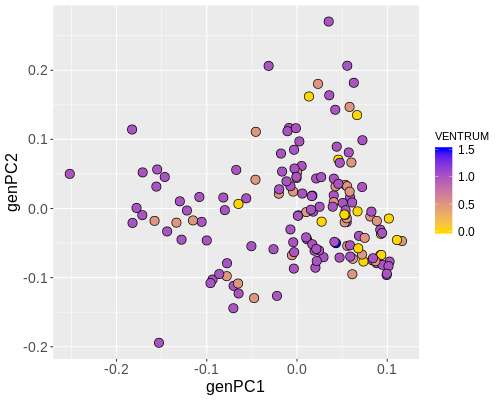

In [104]:
%%R -w 500 -h 400

# visually inspect correlation

left_join(pheno_master_miss50perc_withPCA, PC_dat, by="ANIMALID") %>% 
    select(ANIMALID,contains("PC"),VENTRUM,RUMPSHAPE,WHISKER) %>%
    ggplot( aes(x=genPC1, y=genPC2, fill=VENTRUM)) + 
        geom_point(size=4, pch=21, color="black") +
        scale_fill_gradient(low="gold", high="blue") +
        theme(axis.text=element_text(size=14), axis.title=element_text(size=16)) +
        theme(legend.text=element_text(size=12))

 ### Double-check (again) that order of samples is the same in vcf and pheno file

In [105]:
samples_miss50perc = list(pheno_master_miss50perc_withPCA['ANIMALID'])

tfam_miss50perc_samples = list(pd.read_csv(os.path.join(
    assoc_dir,'POALB.biallelic.miss50perc.maf0.05geno0.5hwe0.001.tfam'), sep=' ', header=None)[0])

samples_miss50perc==tfam_miss50perc_samples

True

## Estimate number of independent markers with GEC

Determining a significance threshold in GWAS seems to be somewhat abitrary and I think it's really more about the singal-to-noise ratio (how different from background is the signal) and the shape of the peak. I'd be wary of highly associated single SNPs. Depending on the markers and population, you'd usually expext a nice peak consisting of multiple markers. But with sparse GT data this is of course more tricky

In [105]:
%%script env assoc_dir="$assoc_dir" bash

maf="0.05"; geno="0.1"; hwe="0.001"
stem="biallelic.miss50perc.maf${maf}geno${geno}hwe${hwe}"

module load Java/1.8

if [ ! -f ${assoc_dir}/out_GEC_POALB.${stem}.block.txt ]; then
    java -Xmx4g -jar ~/bin/gec.jar --no-web --effect-number --genome --maf $maf --plink-binary \
    ${assoc_dir}/POALB.${stem} \
    --out ${assoc_dir}/out_GEC_POALB.${stem}; fi

In [10]:
%%script env assoc_dir="$assoc_dir" bash

maf="0.05"; geno="0.5"; hwe="0.001"
stem="biallelic.miss50perc.maf${maf}geno${geno}hwe${hwe}"

column -t ${assoc_dir}/out_GEC_POALB.${stem}.sum

Observed_Number  Effective_Number  Effective_Ratio  Suggestive_P_Value  Significant_P_Value  Highly_Significant_P_Value
6547             4071.9            0.62             2.46E-4             1.23E-5              2.46E-7


## EMMAX

### Generate Balding-Nichols (BN) kinship matrix

In [88]:
%%script env assoc_dir="$assoc_dir" bash

maf="0.05"; geno="0.5"; hwe="0.001"
stem="biallelic.miss50perc.maf${maf}geno${geno}hwe${hwe}"

if [ ! -f ${assoc_dir}/POALB.${stem}.BN.kinf ]; then
    
    emmax-kin -v -d 10 ${assoc_dir}/POALB.${stem}; fi

### Run model

In [51]:
%%script env assoc_dir="$assoc_dir" emmax_dir="$emmax_dir"  traits="$traits" bash

maf="0.05"; geno="0.5"; hwe="0.001"
stem="biallelic.miss50perc.maf${maf}geno${geno}hwe${hwe}"

for trait in $(echo $traits | sed "s/'//g; s/,//g; s/\[//g; s/\]//g")
do   
    if [ ! -f ${emmax_dir}/out_emmax_POALB.${stem}.BN.${trait}.ps ]; then
        emmax -v -d 5 -t ${assoc_dir}/POALB.${stem} \
        -p ${assoc_dir}/pheno_miss50perc_${trait}.tsv \
        -k ${assoc_dir}/POALB.${stem}.BN.kinf \
        -o ${emmax_dir}/out_emmax_POALB.${stem}.BN.${trait}
        
        sed -i 's/:/\t/; s/chrX/chr100/; s/chr//' ${emmax_dir}/out_emmax_POALB.${stem}.BN.${trait}.ps; fi
done

### Manhattan plots

In [52]:
%%R -i emmax_dir -w 900 -h 300 -i traits

setwd(emmax_dir)

maf = "0.05"; geno="0.5"; hwe="0.001"
stem = paste0("biallelic.miss50perc.maf",maf,"geno",geno,"hwe",hwe)

#pdf(paste("out_emmax.POALB",stem,"pdf",sep="."),width=12,height=4)

for (trait in traits){
#print(trait)
    #trait = "PC1"

        name = paste("out_emmax_POALB",stem,"BN",trait,"ps",sep=".")
        input <- read.table(name, head=F, skip=0, sep="\t", na.string="-nan")
        col.names <- c("CHR", "BP", "BETA", "P")
        colnames(input) <- col.names; input <- na.omit(input); input$ID <- c(1:(nrow(input)))

        upbound <- abs(round(min(log10(input$P))))+1

        #pdf(paste("out_emmax.POALB",stem,trait,"pdf",sep="."),width=9.5,height=4)
        png(paste("out_emmax.POALB",stem,trait,"png",sep="."),width=912,height=384)

        manhattan(input, p="P", snp="ID", logp=T, suggestiveline=F, genomewideline=4.91, main=trait, #genomewideline=4.91
                  col=c("gray", "black"), ylab="-log10(p-value)", ylim=c(0,upbound), cex=0.8)
        dev.off()

}

#dev.off()

### QQ plots

See here for a brief discussion of GWAS and QQ plots http://genomesunzipped.org/2010/07/how-to-read-a-genome-wide-association-study.php

In [209]:
%%R -i emmax_dir -i traits -w 600 -h 600 

setwd(emmax_dir)

maf = "0.05"; geno="0.5"; hwe="0.001"
stem = paste0("biallelic.miss50perc.maf",maf,"geno",geno,"hwe",hwe)

#pdf(paste("out_emmax.POALB",stem,"qq.pdf",sep="."),width=6,height=6)

#for (trait in traits){
trait = "PC1"

        name = paste("out_emmax_POALB",stem,"BN",trait,"ps",sep=".")
        input <- read.table(name, head=F, skip=0, sep="\t", na.string="-nan")
        col.names <- c("CHR", "BP", "BETA", "P")
        colnames(input) <- col.names; input <- na.omit(input); input$ID <- c(1:(nrow(input)))
    
        pdf(paste("out_emmax.POALB",stem,trait,"qq.pdf",sep="."),width=6,height=6)

        qq.chisq(-2*log(input$P), df=2, pvals=T, conc=c(0.025, 0.975), trim=0.5, main=paste0("QQ plot - ",trait),
            overdisp=T, slope.one=T, slope.lambda=T, thin=c(0.25,50), pch=20, oor.pch=24, col.shade="gray90")
    
        dev.off()
#}

#dev.off()

png 
  2 


## Effect size

In [133]:
%%R -i assoc_dir

setwd(assoc_dir)

maf = "0.05"; geno="0.5"; hwe="0.001"
stem = paste0("POALB.biallelic.miss50perc.maf",maf,"geno",geno,"hwe",hwe)

vcf_file = file.path(assoc_dir,paste0(stem,".vcf"))

# read in vcf
vcf <- read.vcfR(vcf_file, verbose=F)

In [134]:
%%R

vcf_nice <- vcfR2tidy(vcf, single_frame=F, toss_INFO_column=T, format_fields = c("GT"))

index <- vcf_nice$fix %>% select(ChromKey,CHROM) %>% unique()
index

R[write to console]: Extracting gt element GT



# A tibble: 24 x 2
   ChromKey CHROM
      <int> <chr>
 1        1 chr1 
 2       12 chr2 
 3       17 chr3 
 4       18 chr4 
 5       19 chr5 
 6       20 chr6 
 7       21 chr7 
 8       22 chr8 
 9       23 chr9 
10        2 chr10
# … with 14 more rows


In [137]:
%%R

vcf_nice$gt %>%
    mutate("GT"=case_when(gt_GT=="0|0" ~ "0/0",
    gt_GT=="0|1" | gt_GT=="1|0" ~ "0/1",
    gt_GT=="1|1" ~ "1/1",
    is.na(gt_GT) ~ "./.",
    TRUE~as.character(gt_GT))) %>% select(Indiv,GT)

# A tibble: 995,144 x 2
   Indiv  GT   
   <chr>  <chr>
 1 VSD142 ./.  
 2 VSD142 0/0  
 3 VSD142 0/1  
 4 VSD142 0/0  
 5 VSD142 0/0  
 6 VSD142 0/1  
 7 VSD142 0/1  
 8 VSD142 0/1  
 9 VSD142 0/0  
10 VSD142 0/0  
# … with 995,134 more rows


In [138]:
%%R

pheno_master_miss50perc_withPCA <- read.table(paste0(assoc_dir,'/pheno_master_miss50perc_withPCA.tsv'),
                                            sep="\t", header=T)

GT_focal <- left_join(pheno_master_miss50perc_withPCA, 
                      vcf_nice$gt %>% filter(ChromKey=="18") %>% filter(POS=="9845301") %>%
                        mutate("GT"=case_when(gt_GT=="0|0" ~ "0/0",
                        gt_GT=="0|1" | gt_GT=="1|0" ~ "0/1",
                        gt_GT=="1|1" ~ "1/1",
                        is.na(gt_GT) ~ "./.",
                        TRUE~as.character(gt_GT))) %>% select(Indiv,GT) %>% rename("ANIMALID"=Indiv),
                      by="ANIMALID") %>% select(ANIMALID,PC1,GT)

In [165]:
%%R -i assoc_dir -w 600 -h 300

ggplot(GT_focal %>% filter(!GT=="./."), aes(x=GT, y=PC1)) +
    geom_boxplot(notch=F, width=0.7) + 
    geom_sina(maxwidth=0.7, pch=16, color="darkgray", size=2.5, alpha=0.8) + 
    ylab("Phenotype PC1 score") + xlab("Genotype chr4:9845301") + 
    scale_fill_manual(values=c("0/0"="#FF9C00","1/1"="#B29977","0/1"="#6495ED")) +
    theme(legend.position="None") +
    theme_classic() +
    theme(axis.text=element_text(size=16), axis.title=element_text(size=18))
    

file_name=paste0(assoc_dir,"/effect_size.PC1.chr4_9845301.pdf")
if(file.exists(file_name)) {
    ggsave(file_name, width=5, height=3)
}

In [338]:
%%R

GT_focal %>% filter(!GT=="./.") %>% group_by(GT) %>% tally()

# A tibble: 3 x 2
  GT        n
  <chr> <int>
1 0/0      98
2 0/1      37
3 1/1       2


In [79]:
%%R

nomiss_GT <- GT_focal %>% filter(!GT=="./.")

model <- lm(nomiss_GT$PC1~nomiss_GT$GT)

summary(model)


Call:
lm(formula = nomiss_GT$PC1 ~ nomiss_GT$GT)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.9844 -1.1132 -0.1025  1.0153  4.1588 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)      -0.8195     0.1591  -5.152 9.03e-07 ***
nomiss_GT$GT0/1   2.2490     0.3039   7.402 1.33e-11 ***
nomiss_GT$GT1/1   5.8127     1.1248   5.168 8.41e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.575 on 134 degrees of freedom
Multiple R-squared:  0.3626,	Adjusted R-squared:  0.3531 
F-statistic: 38.12 on 2 and 134 DF,  p-value: 7.826e-14



### Effect size by beta and freq

In [39]:
%%script env emmax_dir="$emmax_dir" bash

# get beta

maf="0.05"; geno="0.5"; hwe="0.001"

awk '$1==4 && $2==9845301 {print}' \
    $emmax_dir/out_emmax_POALB.biallelic.miss50perc.maf${maf}geno${geno}hwe${hwe}.BN.PC1.ps

4	9845301	-2.3228	4.8812e-10


In [109]:
%%R

beta_sq = abs(-2.3228^2)

print(beta_sq)

[1] 5.3954


In [104]:
%%R

# get ref and alt allele freqs

hom_ref <- nomiss_GT %>% group_by(GT) %>% summarise(n=n()) %>% mutate(freq=n/sum(n)) %>% filter(GT=="0/0") %>% 
    select(freq)
het <- nomiss_GT %>% group_by(GT) %>% summarise(n=n()) %>% mutate(freq=n/sum(n)) %>% filter(GT=="0/1") %>% 
    select(freq)
hom_alt <- nomiss_GT %>% group_by(GT) %>% summarise(n=n()) %>% mutate(freq=n/sum(n)) %>% filter(GT=="1/1") %>% 
    select(freq)

freq_ref = hom_ref + het/2
freq_alt = hom_alt + het/2

print(freq_ref)
print(freq_alt)

R[write to console]: Error in .[1, 1] : incorrect number of dimensions
Calls: <Anonymous> ... eval -> _fseq -> freduce -> withVisible -> <Anonymous>

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In var(., PC1) :
R[write to console]:  NAs introduced by coercion




Error in .[1, 1] : incorrect number of dimensions
Calls: <Anonymous> ... eval -> _fseq -> freduce -> withVisible -> <Anonymous>


In [111]:
%%R

# trait variance

Vtrait = nomiss_GT %>% select(PC1) %>% var()

Vtrait

         PC1
PC1 3.833577


PVE = 
VSNP/VTRAIT

Where VSNP equals:

2 * (REF_ALLELE_COUNT/TOTAL_ALLELE_COUNT) *
(ALT_ALLELE_COUNT/TOTAL_ALLELE_COUNT) * 
(BETA^2)

In [115]:
%%R

Vsnp = 2 * freq_ref * freq_alt * beta_sq

PVE = Vsnp/Vtrait

print(paste0("PVE for PC1 is: ",round(PVE*100,3)," %"))

[1] "PVE for PC1 is: 35.817 %"


## LD

### Calculate pairwise LD (R2) between all SNPs in focal region

In [49]:
%%script env results_dir="$results_dir" bash

if [ ! -d ${results_dir}/LD ]; then mkdir ${results_dir}/LD; fi

stem="POALB.biallelic.miss50perc.maf0.05geno0.5hwe0.001"

if [ ! -f ${results_dir}/LD/${stem} ]; then
plink --bfile ${results_dir}/association/${stem} \
    --chr chr4 --from-bp 9820301 --to-bp 9870301 --r2 --ld-window-r2 0 --ld-window 1000 \
    --out ${results_dir}/LD/${stem}

sed -r -i 's/^\s+//; s/\s$//; s/\s+/\t/g' ${results_dir}/LD/${stem}.ld; fi

PLINK v1.90b6.15 64-bit (21 Jan 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /n/holylfs03/LABS/hoekstra_lab/Users/akautt/projects/Peromyscus_polionotus/results/LD/POALB.biallelic.miss50perc.maf0.05geno0.5hwe0.001.log.
Options in effect:
  --bfile /n/holylfs03/LABS/hoekstra_lab/Users/akautt/projects/Peromyscus_polionotus/results/association/POALB.biallelic.miss50perc.maf0.05geno0.5hwe0.001
  --chr chr4
  --from-bp 9820301
  --ld-window 1000
  --ld-window-r2 0
  --out /n/holylfs03/LABS/hoekstra_lab/Users/akautt/projects/Peromyscus_polionotus/results/LD/POALB.biallelic.miss50perc.maf0.05geno0.5hwe0.001
  --r2
  --to-bp 9870301

128676 MB RAM detected; reserving 64338 MB for main workspace.
82 out of 6547 variants loaded from .bim file.
152 people (0 males, 0 females, 152 ambiguous) loaded from .fam.
Ambiguous sex IDs written to
/n/holylfs03/LABS/hoekstra_lab/Users/akautt/projects/Peromyscus_poliono

phenotypes to be ignored, use the --allow-no-sex flag.


### Load into R and prep data

In [60]:
%%R -i results_dir -i emmax_dir

stem = "POALB.biallelic.miss50perc.maf0.05geno0.5hwe0.001"

LD_data = read.table(paste0(results_dir,"/LD/",stem,".ld"), sep="\t", header=T)

assoc_data = read.table(paste0(emmax_dir,"/out_emmax_",stem,".BN.PC1.ps"), sep="\t", header=F,
        col.names=c("CHR","POS","BETA","P"))

In [70]:
%%R

LD_focal <- LD_data %>% filter(BP_A=="9845301" | BP_B=="9845301") %>%
                mutate("POS"=case_when(BP_B=="9845301" ~ BP_A,
                                      BP_A=="9845301" ~ BP_B)) %>%
                select("CHR"=CHR_A,POS,R2) %>%
                add_row(CHR=4, POS=9845301, R2=1) %>%
                arrange(POS)

### Association and LD plot

In [175]:
%%R

LD_focal

   CHR     POS          R2
1    4 9820816 2.31826e-03
2    4 9821639 2.11211e-02
3    4 9822123 6.23060e-03
4    4 9822798 2.48218e-02
5    4 9837296 1.66258e-01
6    4 9837344 6.72978e-03
7    4 9837401 3.34462e-01
8    4 9841443 8.22344e-01
9    4 9842079 8.38321e-01
10   4 9842105 1.97505e-01
11   4 9843200 7.81701e-01
12   4 9844165 3.43867e-01
13   4 9844209 2.17156e-01
14   4 9844849 7.55633e-01
15   4 9844852 2.75629e-01
16   4 9844869 7.42422e-01
17   4 9844930 7.62019e-01
18   4 9844954 7.51152e-01
19   4 9844955 7.21868e-01
20   4 9845040 6.98754e-01
21   4 9845116 8.45087e-01
22   4 9845136 8.17976e-01
23   4 9845152 9.06468e-01
24   4 9845301 1.00000e+00
25   4 9845470 7.34652e-01
26   4 9846196 9.07332e-03
27   4 9846254 3.95588e-01
28   4 9846286 6.22572e-01
29   4 9846292 6.43050e-01
30   4 9846293 6.70033e-01
31   4 9846308 6.33051e-01
32   4 9846815 7.89449e-01
33   4 9846908 8.38321e-01
34   4 9846919 3.34462e-01
35   4 9846954 4.36348e-01
36   4 9846977 5.62369e-01
3

In [176]:
%%R -i results_dir -w 600 -h 500

left_join(LD_focal, assoc_data, by=c("CHR","POS")) %>%
    ggplot() + 
        geom_point(aes(x=POS, y=-log10(P), fill=R2), pch=21, color="black", size=2) +
        scale_fill_gradientn(colours=c("white","#FBF6B2","#FECB54","#F68930","#ED3124","#BA1F24"),
            values=c(0,0.2,0.4,0.6,0.8,1.0), limits=c(0,1), 
            guide=guide_colorbar(frame.colour="black")) +
        ylim(-2,10) + ylab("-log10(p-value)") + xlab("Position") +
        theme_classic() +
        theme(axis.text=element_text(size=12), axis.title=element_text(size=14)) +
        geom_hline(yintercept=4.91, size=0.5, color="gray50", linetype="dashed") +
        geom_segment(x=9820301, xend=9856015, y=-2, yend=-2, size=0.5, color="gray50") +
        geom_segment(x=9831100, xend=9831184, y=-2, yend=-2, size=7, color="gray50") +
        geom_segment(x=9831224, xend=9831321, y=-2, yend=-2, size=7, color="gray50") +
        geom_segment(x=9837604, xend=9837757, y=-2, yend=-2, size=7, color="gray50") +
        geom_segment(x=9850098, xend=9850152, y=-2, yend=-2, size=7, color="gray50") +
        geom_segment(x=9850932, xend=9851101, y=-2, yend=-2, size=7, color="gray50") +
        geom_segment(x=9852831, xend=9852919, y=-2, yend=-2, size=7, color="gray50") +
        geom_segment(x=9855628, xend=9856015, y=-2, yend=-2, size=7, color="gray50")

out_file = paste0(results_dir,"/LD/Agouti.assoc_LD.pdf")
ggsave(out_file, width=6, height=3)

### LD triangle

In [174]:
%%R -w 600 -h 500 

LD_data %>% as.data.frame() %>% select(-c(SNP_A,SNP_B,CHR_A,CHR_B)) %>% 
    mutate(BP_A=as.factor(BP_A),BP_B=as.factor(BP_B)) %>%
    ggplot(aes(x=BP_A, y=reorder(BP_B, desc(BP_B)), color=R2)) +
        geom_point(size=2.6, shape=15) +
        theme_classic() + theme(legend.position="None") +
        theme(axis.text.x = element_text(angle=45,vjust=1,hjust=1,size=10)) + #, legend.position="left") +
        theme(axis.text.y = element_text(size=10)) +
        scale_colour_gradientn(colours=c("white","#FBF6B2","#FECB54","#F68930","#ED3124","#BA1F24"),
            values=c(0,0.2,0.4,0.6,0.8,1.0), limits=c(0,1)) 

out_file = paste0(results_dir,"/LD/Agouti.LD_triangle.pdf")
ggsave(out_file, width=6, height=6)